In [3]:
from pkg_ML_V1 import *

train_df = pd.read_csv("Generated_Data/Qubits_4_TS_10_Shots_500.csv")
# test_df = pd.read_csv("Z_values_100.csv")
Output_columns = ['W_0', 'W_1', 'W_2','W_3','J_0','J_1','J_2']+['decay_0','decay_1','decay_2','decay_3']
drop_out_columns = Output_columns

Time_stamps_amount = 10
Qubits_amount = 4
Columns_per_time_stamp = 2 * Qubits_amount - 1  # Assuming we measure <z_i>, and <z_ij>. ij are neighbors.

feature_columns = train_df.columns.drop(drop_out_columns)

inputs = {column: tf.keras.layers.Input(shape=(1,), name=column) for column in feature_columns}
concatenated_inputs = tf.keras.layers.concatenate(inputs.values())

# Prepare training data
train_features = {column: train_df[column] for column in inputs}
train_labels = train_df[Output_columns]
# Prepare test data
# test_features = {column: test_df[column] for column in inputs}
# test_labels = test_df[Output_columns]

# Now, for the RNN, we define the time series data:


input_shape = (Time_stamps_amount, Columns_per_time_stamp)  # 10 timestamps, each with 100 measurements
inputs_sequential = tf.keras.layers.Input(shape=input_shape, name='sequential_input')

reshape_shape = (-1, Time_stamps_amount, Columns_per_time_stamp)

train_features_sequential = train_df[feature_columns].to_numpy().reshape(reshape_shape)
train_labels_sequential = train_df[Output_columns]
# test_features_sequential = test_df[feature_columns].to_numpy().reshape(reshape_shape)
# test_labels_sequential = test_df[Output_columns]



Define the neural network create and train models
===========

In [4]:
def create_relu_model(neurons_, learning_rate_, concatenated_inputs_):
    hidden_layer_1 = tf.keras.layers.Dense(neurons_, activation='relu')(concatenated_inputs_)
    hidden_layer_2 = tf.keras.layers.Dense(neurons_, activation='relu')(hidden_layer_1)
    hidden_layer_3 = tf.keras.layers.Dense(neurons_, activation='relu')(hidden_layer_2)
    hidden_layer_4 = tf.keras.layers.Dense(neurons_, activation='relu')(hidden_layer_3)
    output = tf.keras.layers.Dense(len(Output_columns))(hidden_layer_4)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    print("Learning rate: " + str(learning_rate_))
    print("Amount of neurons: " + str(neurons_))

    return model


def create_lstm_model(neurons, learning_rate, inputs):
    x = tf.keras.layers.LSTM(neurons, return_sequences=True)(inputs)
    x = tf.keras.layers.LSTM(neurons, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(neurons, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(neurons)(x)
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(Output_columns))(x)  # Output layer with 3 units

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model



def create_bidirectional_lstm_model(neurons, learning_rate, inputs):
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True))(inputs)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(neurons))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    x = tf.keras.layers.Dense(neurons, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(Output_columns))(x)  # Output layer with 3 units

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model



Creating and Training the ML:
===================

In [5]:
learning_rate = 10 ** -4
epochs = 1
batch_size = 2 ** 6
neurons = 2 ** 10
print("batch size: " + str(batch_size))
model = create_relu_model(neurons, learning_rate, concatenated_inputs)

history = train_model(model, train_features, train_labels,
                      epochs, batch_size, validation_split=0.1)

#training_func takes history and additional epochs as input and output the new history
training_func = lambda  history_,additional_epochs_:train_more(history_, model, train_features, train_labels, additional_epochs_,
               batch_size, 0.1)

batch size: 256
Learning rate: 1e-05
Amount of neurons: 512


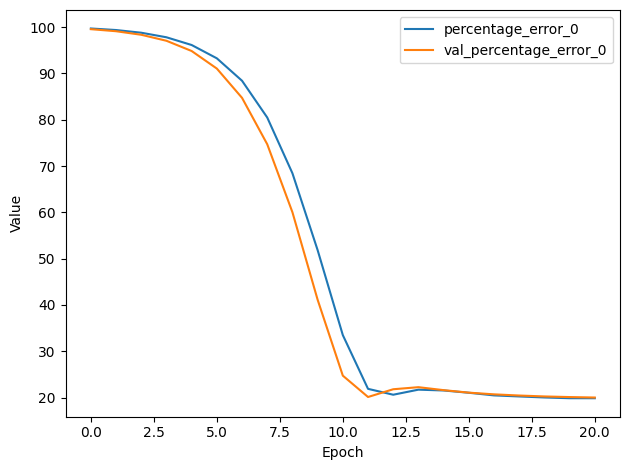

In [6]:


list_of_metrics_to_plot = ['mean_squared_error', 'val_mean_squared_error']

history = live_train(training_func,history,5,50,list_of_metrics_to_plot)


In [7]:
print(history[1]['loss'][len(history[1]['loss'])-1])
print(history[1]['val_loss'][len(history[1]['val_loss'])-1])


1.3598335981369019
1.3493962287902832
19.869384765625
20.0233154296875


Alternative ML Models:
==========

In [8]:
learning_rate = 10 ** -4
epochs = 1
batch_size = 2 ** 10
neurons = 2 ** 8
print("batch size: " + str(batch_size))
print("number of neurons: " + str(neurons))
model_lstm = create_bidirectional_lstm_model(neurons, learning_rate, inputs_sequential)

history_lstm = train_model(model_lstm, train_features_sequential, train_labels_sequential,
                      epochs, batch_size, validation_split=0.1)

#training_func takes history and additional epochs as input and output the new history
training_func = lambda  history_,additional_epochs_:train_more(history_, model_lstm, train_features_sequential, train_labels_sequential, additional_epochs_,
               batch_size, 0.1)


batch size: 1024
number of neurons: 256


NameError: name 'create_bidirectional_lstm_model' is not defined

In [ ]:
list_of_metrics_to_plot = ['mean_squared_error', 'val_mean_squared_error']
history_lstm = live_train(training_func,history_lstm,5,50,list_of_metrics_to_plot)


In [ ]:
print(history_lstm[1]['loss'][len(history_lstm[1]['loss'])-1])
print(history_lstm[1]['val_loss'][len(history_lstm[1]['val_loss'])-1])